In [1]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [27]:
from transformers import BertTokenizer, BertModel
import torch
from sklearn.model_selection import train_test_split
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from transformers import get_scheduler
import matplotlib.pyplot as plt
import os
from sklearn.metrics import precision_recall_fscore_support
from collections import defaultdict
import torch


In [9]:
#data = pd.read_csv('/content/drive/MyDrive/TwitterProje/models/modelData100k.csv')
data = pd.read_csv('./modelData100k.csv')

In [10]:
X = data["text"]
y = data["priority"]
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
label_mapping

{'Acil': 0, 'Bilgilendirme': 1, 'Destek': 2, 'Çok Acil': 3}

In [11]:
data = data.groupby("priority").apply(lambda x: x.sample(n=50000, random_state=42)).reset_index(drop=True)

ValueError: Cannot take a larger sample than population when 'replace=False'

In [12]:
data['priority'].value_counts()

priority
Destek           25000
Bilgilendirme    25000
Acil             25000
Çok Acil         25000
Name: count, dtype: int64

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify=y_train
)
X_train,y_train,X_val

(17098                        adana tekrar kötü hisset koru
 93048    insan tarih ağır deprem maruz kal binlerce yıl...
 27398    yangın varhatay antakya rönesans rezidans patl...
 69116    sev abi mustafa özkan sümbül hak özkan seyran ...
 20521                                            görün yüz
                                ...                        
 78076    adıyaman maraş antep yar gel düzgün enkaz alt ...
 49524    an elbistan pınarbaşı mahalle güneş site göçük...
 41234                               enkaz alt kurtar yavru
 80211         acil yar kişi teyze gil enkaz alt haber alın
 21933                                     geçmiş baş sağol
 Name: text, Length: 72000, dtype: object,
 array([2, 3, 1, ..., 1, 3, 2]),
 73431    cebrail mahalle şehit yaşa özdil sokak ceren a...
 77515    acı̇lll yar yayalımmm odabaş mahalle kanat cad...
 91769    yaş çocuk ism yunus emr enkaz alt iskenderun k...
 79196    gece meydan gelen göçük alt kal binlerce insa ...
 77300    sakarya deprem

In [14]:
print("Train sınıf oranları:", np.bincount(y_train) / len(y_train))
print("Test sınıf oranları:", np.bincount(y_test) / len(y_test))
print("Validation sınıf oranları:", np.bincount(y_val) / len(y_val))

Train sınıf oranları: [0.25 0.25 0.25 0.25]
Test sınıf oranları: [0.25 0.25 0.25 0.25]
Validation sınıf oranları: [0.25 0.25 0.25 0.25]


In [15]:
counts = np.bincount(y_train)
for i, count in enumerate(counts):
    print(f"{i} değeri: {count} kez")

0 değeri: 18000 kez
1 değeri: 18000 kez
2 değeri: 18000 kez
3 değeri: 18000 kez


In [16]:
counts = np.bincount(y_test)
for i, count in enumerate(counts):
    print(f"{i} değeri: {count} kez")

0 değeri: 5000 kez
1 değeri: 5000 kez
2 değeri: 5000 kez
3 değeri: 5000 kez


In [17]:
counts = np.bincount(y_val)
for i, count in enumerate(counts):
    print(f"{i} değeri: {count} kez")

0 değeri: 2000 kez
1 değeri: 2000 kez
2 değeri: 2000 kez
3 değeri: 2000 kez


In [18]:
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-turkish-uncased')
model = BertForSequenceClassification.from_pretrained('dbmdz/bert-base-turkish-uncased', num_labels=len(set(y)))
def tokenize_data(texts, tokenizer, max_length=128):
    return tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors='pt')

train_encodings = tokenize_data(X_train.astype(str).tolist(), tokenizer)
test_encodings = tokenize_data(X_test.astype(str).tolist(), tokenizer)
val_encodings = tokenize_data(X_val.astype(str).tolist(), tokenizer)

c:\Users\Enes\anaconda3\envs\gputorch\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, y_train.tolist())
test_dataset = CustomDataset(test_encodings, y_test.tolist())
val_dataset = CustomDataset(val_encodings, y_val.tolist())

In [20]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256)
val_loader = DataLoader(val_dataset, batch_size=256)

optimizer = AdamW(model.parameters(), lr=2e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

c:\Users\Enes\anaconda3\envs\gputorch\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

<ipython-input-31-5ec4daf39529>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 1/10 - Train Loss: 0.6085 - Val Loss: 0.4991
Epoch 2/10 - Train Loss: 0.3779 - Val Loss: 0.3567
Epoch 3/10 - Train Loss: 0.2944 - Val Loss: 0.2818
Epoch 4/10 - Train Loss: 0.2412 - Val Loss: 0.3226
Epoch 5/10 - Train Loss: 0.1954 - Val Loss: 0.2804
Epoch 6/10 - Train Loss: 0.1624 - Val Loss: 0.3048
Epoch 7/10 - Train Loss: 0.1305 - Val Loss: 0.3013
Epoch 8/10 - Train Loss: 0.1028 - Val Loss: 0.2996
Epoch 9/10 - Train Loss: 0.0827 - Val Loss: 0.3053
Epoch 10/10 - Train Loss: 0.0704 - Val Loss: 0.3368


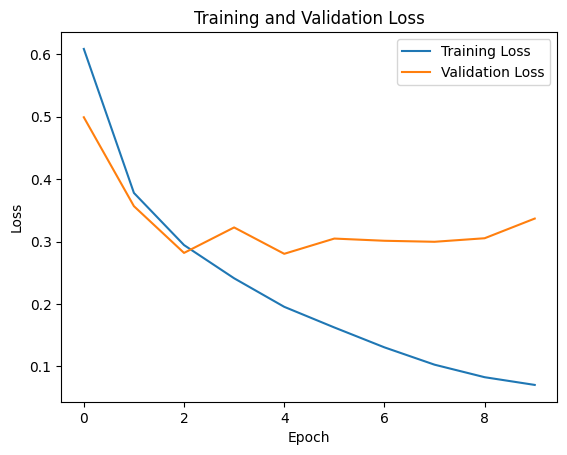

In [ ]:
epochs = 10
train_losses = []
val_losses = []
save_path = "/content/drive/MyDrive/TwitterProje/models/model_checkpoints/"
os.makedirs(save_path, exist_ok=True)
for epoch in range(epochs):
    # Eğitim Modu
    model.train()
    epoch_train_loss = 0
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Doğrulama Modu
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            epoch_val_loss += loss.item()

    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss
    }
    torch.save(checkpoint, f"{save_path}checkpoint_epoch_{epoch + 1}.pt")

# Eğitim ve doğrulama kayıplarını görselleştirme
plt.plot(range(epochs), train_losses, label='Training Loss')
plt.plot(range(epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [21]:
#checkpoint = torch.load("/content/drive/MyDrive/TwitterProje/models/model_checkpoints/checkpoint_epoch_3.pt")
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-turkish-uncased')
model = BertForSequenceClassification.from_pretrained('dbmdz/bert-base-turkish-uncased', num_labels=4)
optimizer = AdamW(model.parameters(), lr=2e-5)
checkpoint = torch.load('../results/checkpoint_epoch_2.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
val_loss = checkpoint['val_loss']

print(f"Yüklenen model epoch: {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

c:\Users\Enes\anaconda3\envs\gputorch\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Yüklenen model epoch: 2, Train Loss: 0.2424, Val Loss: 0.2881


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

# Test

In [23]:
model.eval()
class_correct = defaultdict(int)
class_total = defaultdict(int)

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        predictions = torch.argmax(outputs.logits, dim=-1)

        # Her sınıf için doğru ve toplam tahminleri takip et
        for label, prediction in zip(batch['labels'], predictions):
            class_total[label.item()] += 1
            if label == prediction:
                class_correct[label.item()] += 1

# Her sınıfın doğruluk oranını hesapla
class_accuracies = {cls: class_correct[cls] / class_total[cls] for cls in class_total}

# Sonuçları yazdır
for cls, acc in class_accuracies.items():
    print(f"Class {cls}: Accuracy {acc:.4f}")

C:\Users\Enes\AppData\Local\Temp\ipykernel_8320\275306685.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
c:\Users\Enes\anaconda3\envs\gputorch\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Class 2: Accuracy 0.9298
Class 1: Accuracy 0.8050
Class 0: Accuracy 0.8362
Class 3: Accuracy 0.9900


# Precision Recall F1-Score

In [29]:
model.eval()
# Tüm gerçek etiketler ve tahminleri depolamak için listeler
all_labels = []
all_predictions = []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        predictions = torch.argmax(outputs.logits, dim=-1)

        # Etiketleri ve tahminleri toplama
        all_labels.extend(batch['labels'].cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

# Precision, Recall ve F1-Score'u hesapla
precision, recall, f1_score, _ = precision_recall_fscore_support(
    all_labels, 
    all_predictions, 
    labels=list(set(all_labels)),  # Tüm sınıf etiketlerini belirler
    average=None  # Her sınıf için ayrı metrikleri hesaplar
)

# Sonuçları yazdır
for cls, (p, r, f1) in enumerate(zip(precision, recall, f1_score)):
    print(f"Class {cls}: Precision: {p:.4f}, Recall: {r:.4f}, F1-Score: {f1:.4f}")


precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    all_labels, 
    all_predictions, 
    average='macro'  # Sınıfların ortalamasını alır
)

precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
    all_labels, 
    all_predictions, 
    average='micro'  # Örneklerin toplamına göre ağırlıklandırılmış metrikler
)

print(f"\nMacro Precision: {precision_macro:.4f}, Macro Recall: {recall_macro:.4f}, Macro F1-Score: {f1_macro:.4f}")
print(f"Micro Precision: {precision_micro:.4f}, Micro Recall: {recall_micro:.4f}, Micro F1-Score: {f1_micro:.4f}")

C:\Users\Enes\AppData\Local\Temp\ipykernel_8320\275306685.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Class 0: Precision: 0.8111, Recall: 0.8362, F1-Score: 0.8234
Class 1: Precision: 0.9092, Recall: 0.8050, F1-Score: 0.8539
Class 2: Precision: 0.9887, Recall: 0.9298, F1-Score: 0.9584
Class 3: Precision: 0.8660, Recall: 0.9900, F1-Score: 0.9239

Macro Precision: 0.8937, Macro Recall: 0.8902, Macro F1-Score: 0.8899
Micro Precision: 0.8902, Micro Recall: 0.8902, Micro F1-Score: 0.8902


# Train Test

In [24]:
model.eval()
class_correct = defaultdict(int)
class_total = defaultdict(int)

with torch.no_grad():
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        predictions = torch.argmax(outputs.logits, dim=-1)

        # Her sınıf için doğru ve toplam tahminleri takip et
        for label, prediction in zip(batch['labels'], predictions):
            class_total[label.item()] += 1
            if label == prediction:
                class_correct[label.item()] += 1

# Her sınıfın doğruluk oranını hesapla
class_accuracies = {cls: class_correct[cls] / class_total[cls] for cls in class_total}

# Sonuçları yazdır
for cls, acc in class_accuracies.items():
    print(f"Class {cls}: Accuracy {acc:.4f}")


C:\Users\Enes\AppData\Local\Temp\ipykernel_8320\275306685.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Class 3: Accuracy 0.9938
Class 0: Accuracy 0.8626
Class 2: Accuracy 0.9380
Class 1: Accuracy 0.8320


# Confusion Matrix

<ipython-input-31-5ec4daf39529>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


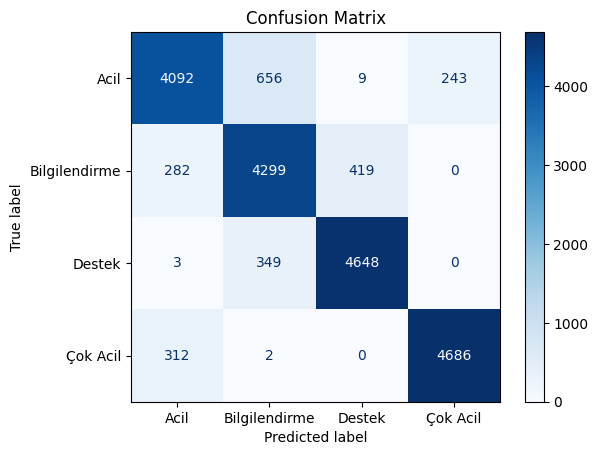

In [ ]:
inverse_label_mapping = {v: k for k, v in label_mapping.items()}  # Numeric-to-class name mapping

# Tüm etiketler ve tahminler için listeler
all_labels = []
all_predictions = []

# Modeli değerlendir ve tahminleri topla
model.eval()
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        predictions = torch.argmax(outputs.logits, dim=-1)

        all_labels.extend(batch['labels'].cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

# Karışıklık matrisini hesapla
cm = confusion_matrix(all_labels, all_predictions)

# Görselleştirme için sınıf isimlerini al
class_labels = [inverse_label_mapping[i] for i in range(len(label_mapping))]

# Karışıklık matrisini görselleştir
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
model.eval()
correct_preds = 0
total_preds = 0

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        predictions = torch.argmax(outputs.logits, dim=-1)
        correct_preds += (predictions == batch['labels']).sum().item()
        total_preds += batch['labels'].size(0)

accuracy = correct_preds / total_preds
print(f"Test Accuracy: {accuracy:.4f}")

<ipython-input-31-5ec4daf39529>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Test Accuracy: 0.8862


In [4]:
def predict_label(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    predicted_label = torch.argmax(logits, dim=1).item()

    return predicted_label

In [10]:
def predict_label(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    predicted_label = torch.argmax(logits, dim=1).item()

    return predicted_label

input_text = "hatay göçük alt deprem oldu yardım edin"
predicted_class = predict_label(input_text)

predicted_label = {v: k for k, v in label_mapping.items()}[predicted_class]
print(predicted_label)

c:\Users\Enes\anaconda3\envs\gputorch\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


NameError: name 'label_mapping' is not defined

# All Data Test And Save

In [5]:
import os
folder_path = "../ParcaliSonuc"

csv_files = [file for file in os.listdir(folder_path) if file.startswith('df') and file.endswith('coordinatesspecialaddress.csv')]

dataframes = []
for csv_file in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    df = pd.read_csv(file_path)
    dataframes.append(df)

combined_df = pd.concat(dataframes, ignore_index=True)
combined_df['content_no_rare_words'] = combined_df['content_no_rare_words'].apply(lambda x: ' '.join(eval(x)))

In [6]:
combined_df['predicted_label'] = combined_df['content_no_rare_words'].apply(predict_label)

c:\Users\Enes\anaconda3\envs\gputorch\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [7]:
combined_df.to_csv("../results/combined_df_label_predected3.csv", index=False)